In [7]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
import os
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import LearningCurveDisplay

In [2]:
RANDOM_STATE = 15

Importar os dados

In [3]:
focos = pd.read_csv("dados/Focos_limpo.csv")
focos = focos.drop(columns=["frp"])
focos = focos.dropna()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(focos.drop(columns=["gravidade"]), focos["gravidade"], shuffle=True, random_state=RANDOM_STATE, test_size=.25)
Counter(y_test).items()

dict_items([(0, 440317), (1, 538)])

### Balanceamento de dados

In [5]:
X_train_balanced, y_train_balanced = ADASYN(random_state=RANDOM_STATE).fit_resample(X_train, y_train)
X_train_undersampled, y_train_undersampled = RandomUnderSampler(random_state=RANDOM_STATE).fit_resample(X_train, y_train)
print(f"Antes (oversample): {Counter(y_train).items()}")
print(f"Depois (oversample): {Counter(y_train_balanced).items()}")
print(f"Antes (undersample): {Counter(y_train).items()}")
print(f"Depois (undersample): {Counter(y_train_undersampled).items()}")

Antes (oversample): dict_items([(0, 1321001), (1, 1564)])
Depois (oversample): dict_items([(0, 1321001), (1, 1321079)])
Antes (undersample): dict_items([(0, 1321001), (1, 1564)])
Depois (undersample): dict_items([(0, 1564), (1, 1564)])


## Treinamento: Multilayer Perceptron

In [6]:
mlp_pipeline = Pipeline([('scaler',  StandardScaler()),
            ('MLPClassifier', MLPClassifier(random_state = RANDOM_STATE, max_iter=20000, tol=10e-10, early_stopping=False, alpha=0.0005, learning_rate='adaptive'))])

In [13]:
mlp_params = {
    "MLPClassifier__hidden_layer_sizes": [(2,),(4,), (8,)],
    "MLPClassifier__alpha": [10e-2, 10e-4],
    "MLPClassifier__activation": ["tanh"],
}
mlp_grid_search = GridSearchCV(mlp_pipeline, mlp_params, scoring="f1", cv=5, verbose=3, n_jobs=10)
mlp_grid_search = mlp_grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 5/5] END MLPClassifier__activation=tanh, MLPClassifier__alpha=0.1, MLPClassifier__hidden_layer_sizes=(2,);, score=0.730 total time= 1.0min
[CV 2/5] END MLPClassifier__activation=tanh, MLPClassifier__alpha=0.1, MLPClassifier__hidden_layer_sizes=(2,);, score=0.727 total time= 1.3min
[CV 4/5] END MLPClassifier__activation=tanh, MLPClassifier__alpha=0.1, MLPClassifier__hidden_layer_sizes=(4,);, score=0.775 total time= 1.6min
[CV 4/5] END MLPClassifier__activation=tanh, MLPClassifier__alpha=0.1, MLPClassifier__hidden_layer_sizes=(2,);, score=0.754 total time= 1.6min
[CV 1/5] END MLPClassifier__activation=tanh, MLPClassifier__alpha=0.1, MLPClassifier__hidden_layer_sizes=(4,);, score=0.779 total time= 1.6min
[CV 3/5] END MLPClassifier__activation=tanh, MLPClassifier__alpha=0.1, MLPClassifier__hidden_layer_sizes=(2,);, score=0.749 total time= 1.7min
[CV 1/5] END MLPClassifier__activation=tanh, MLPClassifier__alpha=0.1, MLPClassifi

In [14]:
mlp_grid_search.best_params_

{'MLPClassifier__activation': 'tanh',
 'MLPClassifier__alpha': 0.001,
 'MLPClassifier__hidden_layer_sizes': (8,)}

<Axes: >

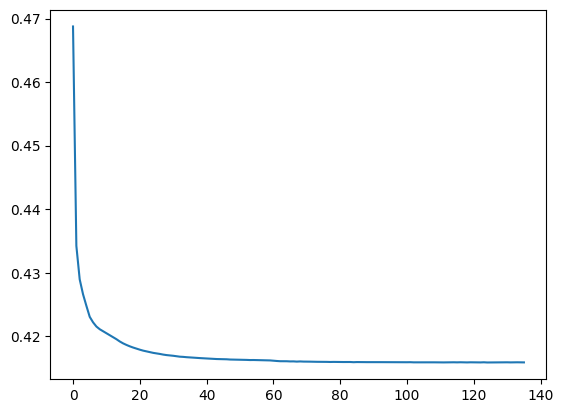

In [15]:
pd.Series(mlp_grid_search.best_estimator_["MLPClassifier"].loss_curve_).plot()

In [16]:
mlp_best_model = mlp_grid_search.best_estimator_
mlp_trained = mlp_best_model.fit(X_train_balanced, y_train_balanced)
mlp_y_pred = mlp_trained.predict(X_test)
mlp_predict_proba = mlp_trained.predict_proba(X_test)
print(f"accuracy_score: {accuracy_score(y_test, mlp_y_pred)}")
print(f"f1_score: {f1_score(y_test, mlp_y_pred)}")
print(f"precision_score: {precision_score(y_test, mlp_y_pred)}")
print(f"recall_score: {recall_score(y_test, mlp_y_pred)}")


accuracy_score: 0.805044742602443
f1_score: 0.007803931981113561
precision_score: 0.0039263518615322065
recall_score: 0.6282527881040892


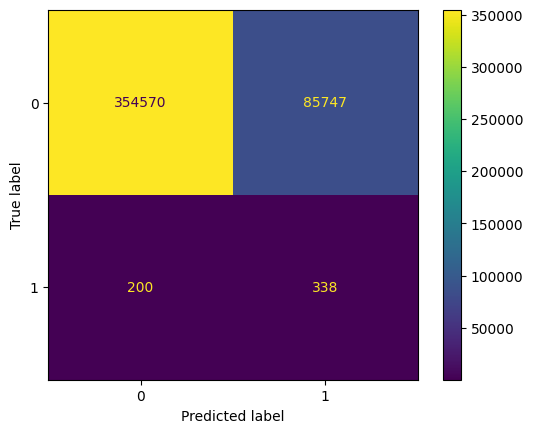

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test, mlp_y_pred)

## Treinamento: Decision Tree

In [18]:
decision_tree_pipeline = Pipeline([('scaler',  StandardScaler()),
            ('DecisionTreeClassifier', DecisionTreeClassifier(random_state = RANDOM_STATE))])
decision_tree_params = {
    "DecisionTreeClassifier__criterion": ['gini', 'entropy', 'log_loss'],
    "DecisionTreeClassifier__max_depth": [e for e in range(4, 11, 2)] + [None]
}
decision_tree_grid_search = GridSearchCV(decision_tree_pipeline, decision_tree_params, scoring="f1", cv=5, verbose=3, n_jobs=8)
decision_tree_grid_search = decision_tree_grid_search.fit(X_train_balanced, y_train_balanced)
decision_tree_grid_search.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END DecisionTreeClassifier__criterion=gini, DecisionTreeClassifier__max_depth=4;, score=0.712 total time=   7.8s
[CV 4/5] END DecisionTreeClassifier__criterion=gini, DecisionTreeClassifier__max_depth=4;, score=0.711 total time=   7.8s
[CV 5/5] END DecisionTreeClassifier__criterion=gini, DecisionTreeClassifier__max_depth=4;, score=0.736 total time=   8.2s
[CV 2/5] END DecisionTreeClassifier__criterion=gini, DecisionTreeClassifier__max_depth=4;, score=0.695 total time=   8.5s
[CV 3/5] END DecisionTreeClassifier__criterion=gini, DecisionTreeClassifier__max_depth=4;, score=0.701 total time=   9.3s
[CV 1/5] END DecisionTreeClassifier__criterion=gini, DecisionTreeClassifier__max_depth=6;, score=0.771 total time=  10.9s
[CV 2/5] END DecisionTreeClassifier__criterion=gini, DecisionTreeClassifier__max_depth=6;, score=0.762 total time=  11.3s
[CV 3/5] END DecisionTreeClassifier__criterion=gini, DecisionTreeClassifier__max_dept

{'DecisionTreeClassifier__criterion': 'entropy',
 'DecisionTreeClassifier__max_depth': None}

In [21]:
decision_tree_best_model = decision_tree_grid_search.best_estimator_
decision_tree_trained = decision_tree_best_model.fit(X_train_balanced, y_train_balanced)
decision_tree_y_pred = decision_tree_trained.predict(X_test)
decision_tree_predict_proba = decision_tree_trained.predict_proba(X_test)
print("DECISION TREE")
print(f"accuracy_score: {accuracy_score(y_test, decision_tree_y_pred)}")
print(f"f1_score: {f1_score(y_test, decision_tree_y_pred)}")
print(f"precision_score: {precision_score(y_test, decision_tree_y_pred)}")
print(f"recall_score: {recall_score(y_test, decision_tree_y_pred)}")

DECISION TREE
accuracy_score: 0.9992469179208583
f1_score: 0.732258064516129
precision_score: 0.6467236467236467
recall_score: 0.8438661710037175


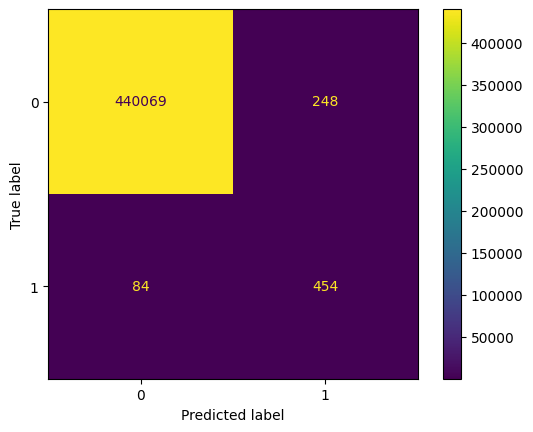

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test, decision_tree_y_pred)

## Treinamento: SGDClassifier

In [23]:
sgd_pipeline = Pipeline([('scaler',  StandardScaler()),
            ('SGDClassifier', SGDClassifier(random_state = RANDOM_STATE, loss='log_loss', tol=1e-100))])
sgd_params = {
    "SGDClassifier__penalty": ['l2', 'elasticnet'],
    "SGDClassifier__max_iter": [10000, 30000, 50000],
    "SGDClassifier__alpha": [10e-2, 10e-4]
}
sgd_grid_search = GridSearchCV(sgd_pipeline, sgd_params, scoring="f1", cv=5, verbose=3, n_jobs=10)
sgd_grid_search = sgd_grid_search.fit(X_train_balanced, y_train_balanced)
sgd_grid_search.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 5/5] END SGDClassifier__alpha=0.1, SGDClassifier__max_iter=10000, SGDClassifier__penalty=l2;, score=0.713 total time=   6.4s
[CV 4/5] END SGDClassifier__alpha=0.1, SGDClassifier__max_iter=10000, SGDClassifier__penalty=l2;, score=0.730 total time=   6.9s
[CV 2/5] END SGDClassifier__alpha=0.1, SGDClassifier__max_iter=10000, SGDClassifier__penalty=l2;, score=0.702 total time=   7.3s
[CV 3/5] END SGDClassifier__alpha=0.1, SGDClassifier__max_iter=10000, SGDClassifier__penalty=l2;, score=0.716 total time=   7.5s
[CV 1/5] END SGDClassifier__alpha=0.1, SGDClassifier__max_iter=10000, SGDClassifier__penalty=l2;, score=0.716 total time=   7.6s
[CV 2/5] END SGDClassifier__alpha=0.1, SGDClassifier__max_iter=10000, SGDClassifier__penalty=elasticnet;, score=0.699 total time=   8.4s
[CV 3/5] END SGDClassifier__alpha=0.1, SGDClassifier__max_iter=10000, SGDClassifier__penalty=elasticnet;, score=0.712 total time=  11.1s
[CV 5/5] END SGDClas

{'SGDClassifier__alpha': 0.001,
 'SGDClassifier__max_iter': 10000,
 'SGDClassifier__penalty': 'l2'}

In [24]:
sgd_best_model = sgd_grid_search.best_estimator_
sgd_trained = sgd_best_model.fit(X_train_undersampled, y_train_undersampled)
sgd_y_pred = sgd_trained.predict(X_test)
sgd_predict_proba = sgd_best_model.predict_proba(X_test)
print("SGD Classifier")
print(f"accuracy_score: {accuracy_score(y_test, sgd_y_pred)}")
print(f"f1_score: {f1_score(y_test, sgd_y_pred)}")
print(f"precision_score: {precision_score(y_test, sgd_y_pred)}")
print(f"recall_score: {recall_score(y_test, sgd_y_pred)}")

SGD Classifier
accuracy_score: 0.6380011568429529
f1_score: 0.004454065114190003
precision_score: 0.002234531968829218
recall_score: 0.6635687732342007


In [25]:
sgd_predict_proba = sgd_best_model.predict_proba(X_test)

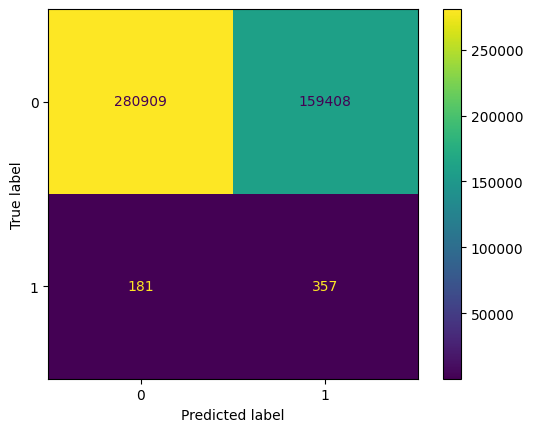

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, sgd_y_pred)

## Treinamento: SVM

In [91]:
svm_pipeline = Pipeline([('scaler',  StandardScaler()),
            ('SVC', SVC(random_state = RANDOM_STATE))])
svm_params = {
    "SVC__kernel": ['rbf', 'sigmoid'],
    "SVC__C": [2**e for e in range(-5, 15 + 1, 2)],
    "SVC__gamma": [2**e for e in range(-15, 3 + 1, 2)] + [2**2]
}
svm_grid_search = GridSearchCV(svm_pipeline, svm_params, scoring="f1", cv=5, verbose=3, n_jobs=4)
svm_grid_search = svm_grid_search.fit(X_train_undersampled, y_train_undersampled)
svm_grid_search.best_params_

Fitting 5 folds for each of 242 candidates, totalling 1210 fits
[CV 3/5] END SVC__C=0.03125, SVC__gamma=3.0517578125e-05, SVC__kernel=rbf;, score=0.707 total time=   0.2s
[CV 4/5] END SVC__C=0.03125, SVC__gamma=3.0517578125e-05, SVC__kernel=rbf;, score=0.666 total time=   0.2s
[CV 1/5] END SVC__C=0.03125, SVC__gamma=3.0517578125e-05, SVC__kernel=rbf;, score=0.653 total time=   0.2s
[CV 2/5] END SVC__C=0.03125, SVC__gamma=3.0517578125e-05, SVC__kernel=rbf;, score=0.677 total time=   0.3s
[CV 5/5] END SVC__C=0.03125, SVC__gamma=3.0517578125e-05, SVC__kernel=rbf;, score=0.000 total time=   0.2s
[CV 1/5] END SVC__C=0.03125, SVC__gamma=3.0517578125e-05, SVC__kernel=sigmoid;, score=0.653 total time=   0.3s
[CV 2/5] END SVC__C=0.03125, SVC__gamma=3.0517578125e-05, SVC__kernel=sigmoid;, score=0.677 total time=   0.3s
[CV 3/5] END SVC__C=0.03125, SVC__gamma=3.0517578125e-05, SVC__kernel=sigmoid;, score=0.706 total time=   0.3s
[CV 4/5] END SVC__C=0.03125, SVC__gamma=3.0517578125e-05, SVC__kerne

{'SVC__C': 2048, 'SVC__gamma': 8, 'SVC__kernel': 'rbf'}

In [92]:
svm_best_model = svm_grid_search.best_estimator_
svm_trained = svm_best_model.fit(X_train_undersampled, y_train_undersampled)
svm_y_pred = svm_trained.predict(X_test)
print("SVM Classifier")
print(f"accuracy_score: {accuracy_score(y_test, svm_y_pred)}")
print(f"f1_score: {f1_score(y_test, svm_y_pred)}")
print(f"precision_score: {precision_score(y_test, svm_y_pred)}")
print(f"recall_score: {recall_score(y_test, svm_y_pred)}")

SGD Classifier
accuracy_score: 0.8410180217985506
f1_score: 0.01439982000224997
precision_score: 0.007254796383937427
recall_score: 0.9516728624535316


In [93]:
confusion_matrix(y_test, svm_y_pred)

array([[370255,  70062],
       [    26,    512]])

# Análise

In [174]:
# common_params = {
#     "X": X_test,
#     "y": y_test,
#     "train_sizes": np.linspace(0.1, 1.0, 5),
#     "score_type": "both",
#     "n_jobs": 4,
#     "line_kw": {"marker": "o"},
#     "std_display_style": "fill_between",
#     "score_name": "F1-score",
#     "scoring": "f1"
# }
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), sharey=True)
# for ax_idx, estimator in enumerate([mlp_best_model, decision_tree_best_model, sgd_best_model]):
#     LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
#     handles, label = ax[ax_idx].get_legend_handles_labels()
#     ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
#     pipeline_name = list(estimator.named_steps.keys())[-1]
#     ax[ax_idx].set_title(f"Learning Curve for {pipeline_name}")

### Curva ROC

In [104]:
mlp_predict_proba[:,0]

array([0.95334389, 0.16845665, 0.8896309 , ..., 0.29921094, 0.98454183,
       0.94217643])

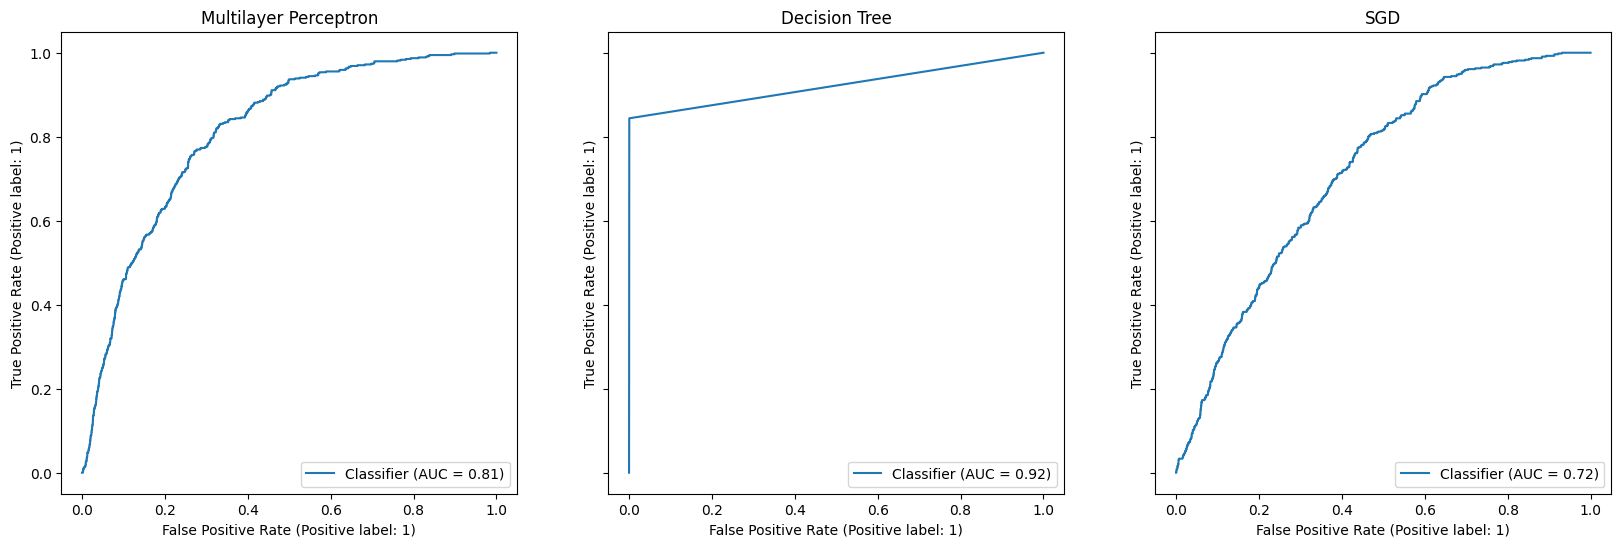

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), sharey=True)
for ax_idx, (estimator, name) in enumerate([(mlp_predict_proba, "Multilayer Perceptron"), (decision_tree_predict_proba, "Decision Tree"), (sgd_predict_proba, "SGD")]):
    RocCurveDisplay.from_predictions(y_test, estimator[:,1], ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    # ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"{name}")

## Curva Precision Recall

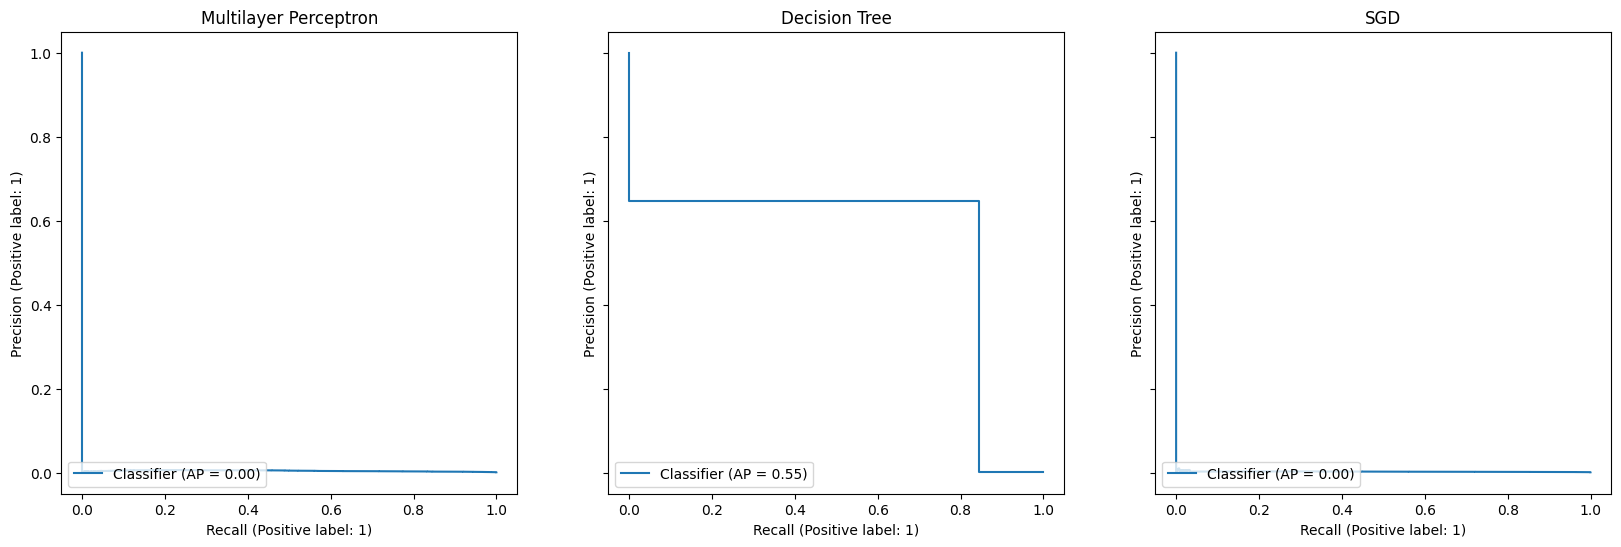

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), sharey=True)
for ax_idx, (estimator, name) in enumerate([(mlp_predict_proba, "Multilayer Perceptron"), (decision_tree_predict_proba, "Decision Tree"), (sgd_predict_proba, "SGD")]):
    PrecisionRecallDisplay.from_predictions(y_test, estimator[:,1], ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].set_title(f"{name}")

## Mapa de erros

/tmp/ipykernel_9736/3566147589.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


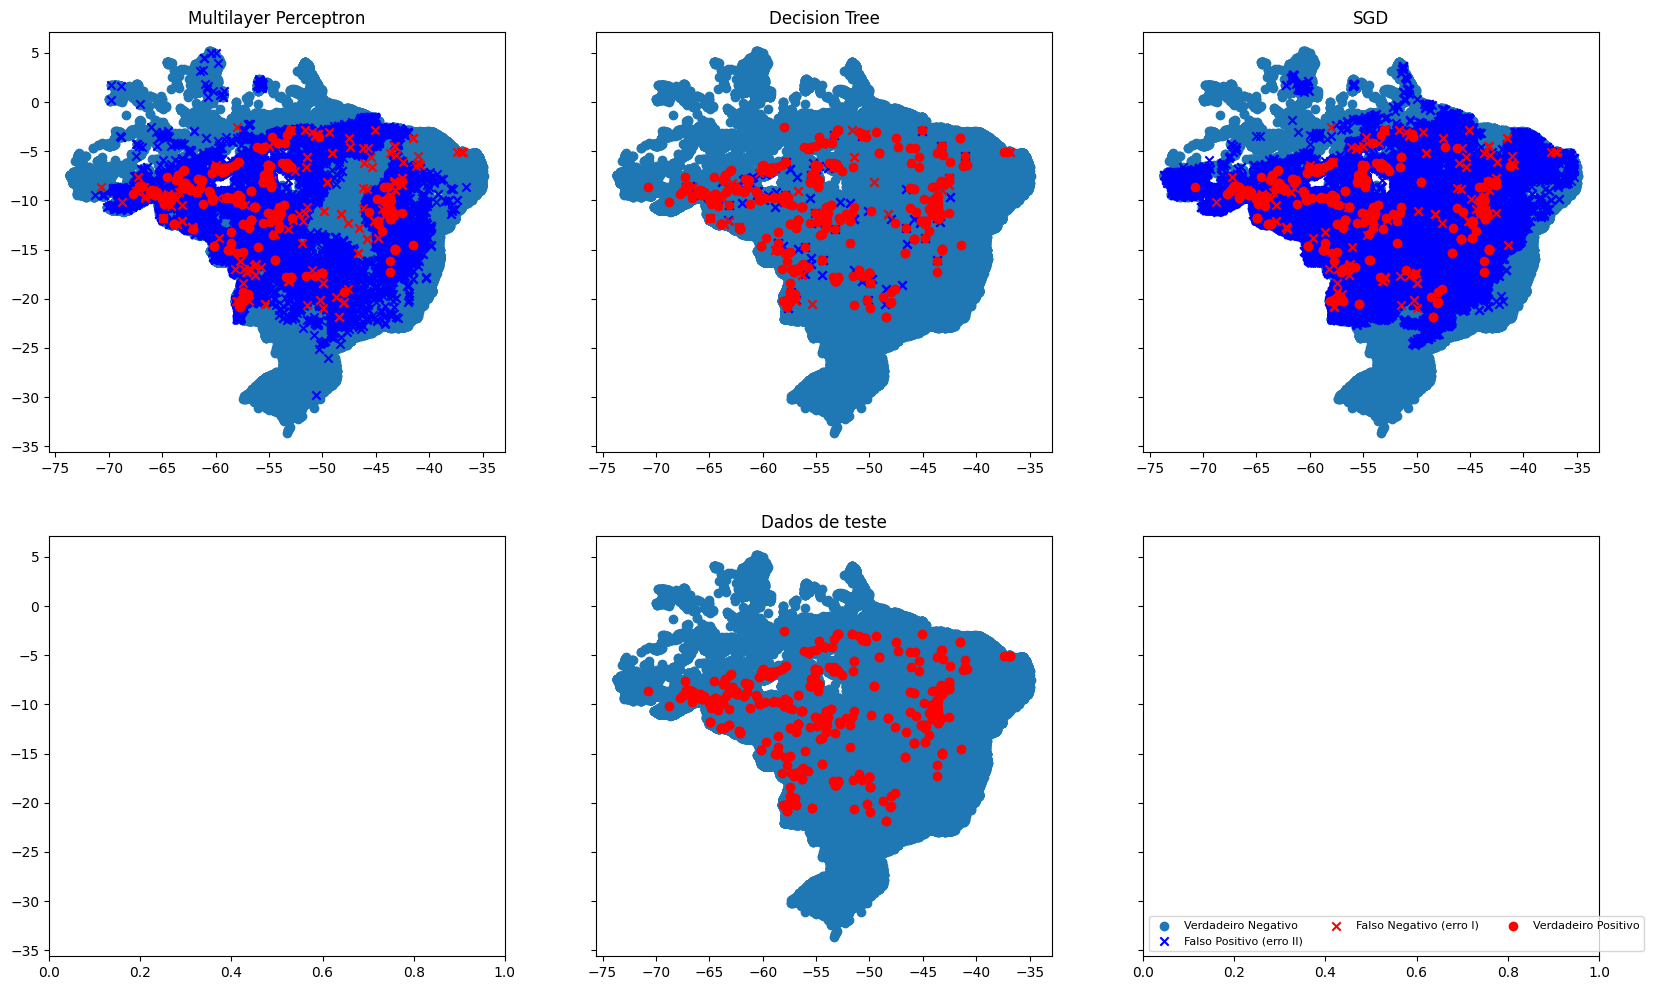

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 12), sharey=True)
for ax_idx, (estimator, name) in enumerate([(mlp_y_pred, "Multilayer Perceptron"), (decision_tree_y_pred, "Decision Tree"), (sgd_y_pred, "SGD")]):
    false_positive = X_test[(y_test == 0) & (estimator == 1)]
    false_negative = X_test[(y_test == 1) & (estimator == 0)]
    true_positive = X_test[(y_test == 1) & (estimator == 1)]
    true_negative = X_test[(y_test == 0) & (estimator == 0)]
    # ax[0][ax_idx].scatter(true_negative["longitude"], true_negative["latitude"], label="sas")
    # ax[0][ax_idx].scatter(false_positive["longitude"], false_positive["latitude"], marker="x", color="orange")
    # ax[0][ax_idx].scatter(false_negative["longitude"], false_negative["latitude"], color="red", marker="x")
    # ax[0][ax_idx].scatter(true_positive["longitude"], true_positive["latitude"], color="green")
    plt.legend((
        ax[0][ax_idx].scatter(true_negative["longitude"], true_negative["latitude"]),
        ax[0][ax_idx].scatter(false_positive["longitude"], false_positive["latitude"], marker="x", color="blue"),
        ax[0][ax_idx].scatter(false_negative["longitude"], false_negative["latitude"], color="red", marker="x"),
        ax[0][ax_idx].scatter(true_positive["longitude"], true_positive["latitude"], color="red"),),
           ('Verdadeiro Negativo', "Falso Positivo (erro II)",'Falso Negativo (erro I)', 'Verdadeiro Positivo'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
    ax[0][ax_idx].set_title(f"{name}")
X_test0 = X_test[y_test == 0]
X_test1 = X_test[y_test == 1]
ax[1][1].scatter(X_test0['longitude'], X_test0['latitude'])
ax[1][1].scatter(X_test1['longitude'], X_test1['latitude'], color='red')
ax[1][1].set_title(f"Dados de teste")
fig.show()